In [1]:
# Import standard libraries
import os
os.environ["OMP_NUM_THREADS"] = '1'
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import time

# ML import
from sklearn import datasets        # datasets
from sklearn.cluster import KMeans  # K-Means algorithm
from sklearn.cluster import AgglomerativeClustering  # Hierarchical clustering
from scipy.cluster.hierarchy import dendrogram, linkage # dendogram visualization

# Clustering

<img src='https://miro.medium.com/v2/resize:fit:4800/format:webp/0*ZxLMBwq9rmW9ZFuZ.jpg' width="800">

Source: [The difference between supervised and unsupervised learning](https://twitter.com/athena_schools/status/1063013435779223553), illustrated by [@Ciaraioch](https://twitter.com/Ciaraioch) 


## Content

The goal of this walkthrough is to provide you with insights on clustering, focusing on two methods: K-Means and Hierarchical clustering. After presenting the main concepts, you will be introduced to the techniques to implement the algorithms in Python. Finally, it will be your turn to practice, using an application on customers of shopping mall.

This notebook is organized as follows:
- [Background](#Background)
    - [Objective](#Objective)
    - [Algorithm overview](#Algorithm-overview)
- [Implementation](#Implementation)
    - [Discover dataset](#Discover-dataset)
    - [K-Means](#K-Means)
        - [Implementing K-Means](#Implementing-K-Means)
        - [Graphical representation](#Graphical-representation)
        - [Elbow method](#Elbow-method)
    - [Hierarchical clustering](#Hierarchical-clustering)
        - [Implementing hierarchical (agglomerative) clustering](#Implementing-hierarchical-(agglomerative)-clustering)
        - [Dendrogram visualization](#Dendrogram-visualization)
    - [Runtime complexity](#Runtime-complexity)
- [Your turn](#Your-turn)

## Background

### Objective

Clustering aims at creating groups of data points with the goal to:
- organize data into classes with high intra-class similarity and low inter-class similarity
- find the class labels and the number of classes directly from the data (vs classification for which classes are defined)
- find natural groupings among objects

Clustering algorithms are thus **unsupervised learning** methods.

### Algorithm overview

Here is a table describing different techniques available with the sklearn module `sklean.cluster`. The [documentation](https://scikit-learn.org/stable/modules/clustering.html) contains detailed description of each technique, you can explore it to deepen your understanding of each algorithm! You can also refer to the [Glossary](https://scikit-learn.org/stable/glossary.html) for definitions of technical terms.

| Method name | Parameters | Usecase | Geometry (metric used) |
| :- | :- | :- | :- |
| [K-Means](https://scikit-learn.org/stable/modules/clustering.html#k-means) | Number of clusters | General-purpose, even cluster size, flat geometry, not too many clusters, inductive | Distances between points|
| [Affinity propagation](https://scikit-learn.org/stable/modules/clustering.html#affinity-propagation) | Damping, sample preference | Many clusters, uneven cluster size, non-flat geometry, inductive | Graph distance (e.g. nearest-neighbor graph)|
| [Mean-shift](https://scikit-learn.org/stable/modules/clustering.html#mean-shift) | Bandwidth | Many clusters, uneven cluster size, non-flat geometry, inductive | Distances between points|
| [Spectral clustering](https://scikit-learn.org/stable/modules/clustering.html#spectral-clustering) | Number of clusters | Few clusters, even cluster size, non-flat geometry, transductive | Graph distance (e.g. nearest-neighbor graph)|
| [Ward hierarchical clustering](https://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering) | Number of clusters or distance threshold | Many clusters, possibly connectivity constraints, transductive | Distances between points|
| [Agglomerative clustering](https://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering) | Number of clusters or distance threshold, linkage type, distance| Many clusters, possibly connectivity constraints, non Euclidean distances, transductive | Any pairwise distance|
| [DBSCAN](https://scikit-learn.org/stable/modules/clustering.html#dbscan) | Neighborhood size | Non-flat geometry, uneven cluster sizes, outlier removal, transductive | Distances between nearest points|
| [OPTICS](https://scikit-learn.org/stable/modules/clustering.html#optics) | Minimum cluster membership | Non-flat geometry, uneven cluster sizes, variable cluster density, outlier removal, transductive | Distances between points|
| [Gaussian mixtures](https://scikit-learn.org/stable/modules/mixture.html#mixture) | Many | Flat geometry, good for density estimation, inductive | Mahalanobis distances to  centers|
| [BIRCH](https://scikit-learn.org/stable/modules/clustering.html#birch) | Branching factor, threshold, optional global clusterer | Large dataset, outlier removal, data reduction, inductive | Euclidean distance between points|
| [Bisecting K-Means](https://scikit-learn.org/stable/modules/clustering.html#bisect-k-means) | Number of clusters | General-purpose, even cluster size, flat geometry, not too many clusters, inductive | Distances between points|




Each method performs differently depending on the input data. They also differ in their complexity. The figure below illustrates these differences - check the computation time bottom right!

<center>
<img src='https://scikit-learn.org/stable/_images/sphx_glr_plot_cluster_comparison_001.png' width="800">
<center/>

Source: [Scikit-learn Clustering Documentation](https://scikit-learn.org/stable/modules/clustering.html)       

## Implementation

### Discover dataset

We're going to use the Iris dataset, which contains measurement for 3 different types of iris flowers: *setosa*, *versicolor*, and *virginica*:

<img src='https://machinelearninghd.com/wp-content/uploads/2021/03/iris-dataset.png' width="600">

The data includes, for each Iris flower, measures of width and length of sepals and petals. The dataset was originally created by Sir R.A. Fisher. We can directly obtain the dataset from `sklearn`, via the `datasets` module, which contains several toy datasets ([Documentation](https://scikit-learn.org/stable/datasets/toy_dataset.html)). Here is the import line:

```python
from sklearn import datasets
```

The Iris dataset is a classic in ML and is often used to discover, for instance, classification, clustering, and dimensionality reduction. Let's discover it!

In [2]:
# Load the Iris dataset from sklearn
iris = datasets.load_iris()

In [3]:
print("The different types of irises are:", iris.target_names)
print("The datatype:", type(iris))

The different types of irises are: ['setosa' 'versicolor' 'virginica']
The datatype: <class 'sklearn.utils._bunch.Bunch'>


The Iris dataset is saved as a set of numpy arrays. We're going to transform it into a pandas dataframe.

**Note:** We could also used the numpy array format for k-means Clustering.

In [4]:
# Note that our dataframe only includes data about the flowers, and NOT the actual type of flowers
X = pd.DataFrame(iris.data, columns=iris.feature_names)
X.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


We have 4 different metrics stored in X. For now we'll work with only the sepal features: "sepal lenght (cm)" and "sepal width (cm)":

In [5]:
# Dataframe with sepal features
X_sepal = X.loc[:, ["sepal length (cm)","sepal width (cm)"]]
X_sepal.head()

,sepal length (cm),sepal width (cm)
0,5.1,3.5
1,4.9,3.0
2,4.7,3.2
3,4.6,3.1
4,5.0,3.6


The species are encoded by labels:

In [6]:
print("Species are encoded as:", iris.target)

Species are encoded as: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


We save these labels in a dataframe, indicating for each observation (flower) which kind it is.

In [7]:
# Dataframe with flower type (labels)
y=pd.DataFrame(iris.target, columns=["Flower_type"])
y.head()

,Flower_type
0,0
1,0
2,0
3,0
4,0


Let's check how many observations we have for each type of flowers:

In [8]:
y.value_counts()

Flower_type
0              50
1              50
2              50
dtype: int64

Let's print some summary statistics, for each type of flower:

In [9]:
# Summary statistics
pd.concat([X_sepal, y], axis=1).groupby(['Flower_type']).describe().loc[:,(slice(None),['max','min','mean'])].transpose().sort_index()

Flower_type                 0      1      2
sepal length (cm) max   5.800  7.000  7.900
                  mean  5.006  5.936  6.588
                  min   4.300  4.900  4.900
sepal width (cm)  max   4.400  3.400  3.800
                  mean  3.428  2.770  2.974
                  min   2.300  2.000  2.200

### K-Means

#### Implementing K-Means

We are using the `KMeans` module of sklearn ([Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans))

```python
from sklearn.cluster import KMeans
```
As parameters, we need to specify `n_clusters`, describing the number of clusters to form as well as the number of centroids to generate. For illustration, we're going to train two K-Means models and fit it on the sepal features (X_sepal):
-   K-means with 3 clusters
-   K-means with 5 clusters

The one with 5 clusters is only for illustration, because we already know that there are only 3 different types of iris in the dataset.

In [10]:

# Create an instance of KMeans and specify the number of clusters=3, 
# Random state help make sure we all have exactly the same results
kmeans3 = KMeans(n_clusters=3, random_state=0, n_init=10) #3 clusters

# Fit the model on the set of features we previously labelled as X_sepal (NOT including the labels on the type of flowers)
kmeans3.fit(X_sepal)

KMeans(n_clusters=3, n_init=10, random_state=0)

We can access the `labels_` of each observation:

In [11]:
print(kmeans3.labels_)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 0 2 0 2 0 2 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0
 2 2 2 2 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 2 2 2 0 2 2 2 2
 2 2 0 0 2 2 2 2 0 2 0 2 0 2 2 0 0 2 2 2 2 2 0 0 2 2 2 0 2 2 2 0 2 2 2 0 2
 2 0]


We can use `cluster_centers_` to obtain the coordinates of the centers generated by the model:

In [12]:
print(kmeans3.cluster_centers_)

[[5.77358491 2.69245283]
 [5.006      3.428     ]
 [6.81276596 3.07446809]]


Let's proceed similarly, this time with 5 clusters:

In [13]:
# Create an instance of KMeans
kmeans5=KMeans(n_clusters=5, random_state=0, n_init=10) #5 clusters

# Fit the model on the X features
kmeans5.fit(X_sepal)

# Labels
print(kmeans5.labels_)

[4 0 0 0 4 4 0 4 0 0 4 4 0 0 4 4 4 4 4 4 4 4 4 4 4 0 4 4 4 0 0 4 4 4 0 0 4
 4 0 4 4 0 0 4 4 0 4 0 4 4 3 3 3 1 3 1 3 0 3 0 0 1 1 1 1 3 1 1 1 1 1 1 1 1
 3 3 3 3 1 1 1 1 1 1 1 3 3 1 1 1 1 1 1 0 1 1 1 1 0 1 3 1 2 3 3 2 0 2 3 2 3
 3 3 1 1 3 3 2 2 1 3 1 2 1 3 2 1 1 3 2 2 2 3 3 1 2 3 3 1 3 3 3 1 3 3 3 1 3
 3 1]


#### Graphical representation

Let's visualize the clusters created, and compare them with the "true" labels (flower types).

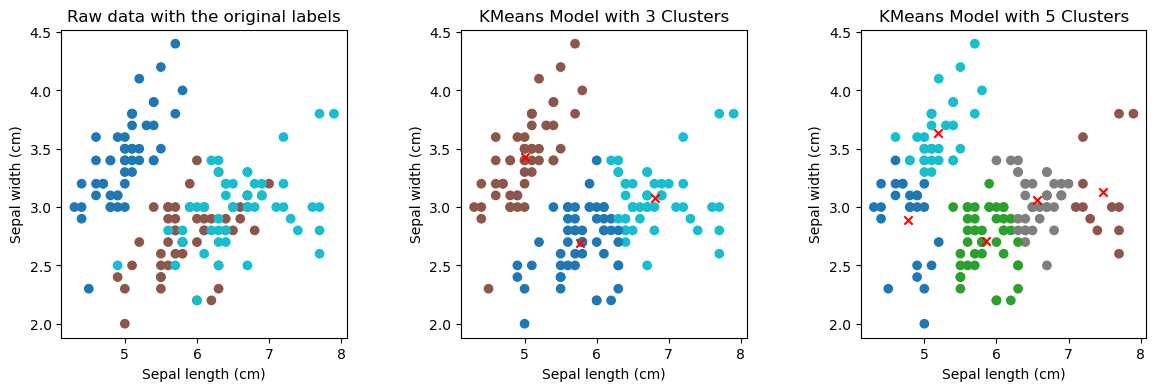

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(14, 4))

# Scatter plot, raw data with original labels
ax[0].scatter(X_sepal["sepal length (cm)"], # x-axis
              X_sepal["sepal width (cm)"],  # y-axis
              c=y['Flower_type'],           # points colored by the different flower types
              cmap='tab10')                 # choice of colors
ax[0].set_xlabel("Sepal length (cm)")       # label x-axis
ax[0].set_ylabel("Sepal width (cm)")        # label y-axis
ax[0].set_title("Raw data with the original labels")  # title

# Scatter plot of clusters, KMeans Model with 3 Clusters
ax[1].scatter(X_sepal["sepal length (cm)"], 
              X_sepal["sepal width (cm)"], 
              c=kmeans3.labels_,              # points colored by the labels created by the model
              cmap='tab10')
ax[1].scatter(kmeans3.cluster_centers_[:, 0],  # x-coordinates of cluster centroids
              kmeans3.cluster_centers_[:, 1],  # y-coordinates of cluster centroids
              c="red",                        # color of centroids
              marker='x')                     # marker of centroids
ax[1].set_xlabel("Sepal length (cm)")
ax[1].set_ylabel("Sepal width (cm)")
ax[1].set_title("KMeans Model with 3 Clusters")

# Scatter plot of clusters, KMeans Model with 5 Clusters
ax[2].scatter(X_sepal["sepal length (cm)"], X_sepal["sepal width (cm)"], c=kmeans5.labels_, cmap='tab10')
ax[2].scatter(kmeans5.cluster_centers_[:, 0], kmeans5.cluster_centers_[:, 1], c="red", marker='x')
ax[2].set_xlabel("Sepal length (cm)")
ax[2].set_ylabel("Sepal width (cm)")
ax[2].set_title("KMeans Model with 5 Clusters")

plt.subplots_adjust(wspace=0.4)   # Space between plots
plt.show()

Our K-Means model with 3 clusters recognizes well the *setosa* (top left cluster), however it struggles to distinguish the *versicolor* and *virginica* since these flowers have interwonen sepal length and width. Note that the original labels and the one created with our model do not match (e.g., *setosa* is label 0 in the original dataset, and 1 in our K-Means model), hence the colors in our plot differ.

How do we assess the performance of our models? In the general case we do not have the target variable (unsupervised learning), so we cannot rely on the metrics used in classification such as the accuracy. Instead, we rely on other metrics such as the **inertia**, which is the sum of squared distances of samples to their closest cluster center, potentially weighted by the sample weights if provided. This is the cost function that the algorithm minimizes. Let's check the inertia of our K-Means models with 3 and 5 clusters:

In [15]:
print("The inertia of the K-Means model with 3 clusters is: {:0.2f}".format(kmeans3.inertia_))
print("The inertia of the K-Means model with 5 clusters is: {:0.2f}".format(kmeans5.inertia_))

The inertia of the K-Means model with 3 clusters is: 37.05
The inertia of the K-Means model with 5 clusters is: 21.00


Which model should we choose? In other words, how many clusters should we pick? We'll explore this question using the Elbow method.

#### Elbow method

We now try to find the "optimal" number of clusters using the [Elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)).  

This method consists in plotting the explained variation (e.g., **inertia**) as a function of the number of clusters, and picking the elbow of the curve as the number of clusters to use. The intuition is that increasing the number of clusters will always improve the fit (explain more of the variation), since there are more parameters (more clusters). However, this will at some point result in **over-fitting**, with only minimal gains in the fit, which the elbow reflects. 

Let's try! We create a loop to iteratively train K-Means algorithms for different values of k, saving the parameter `inertia_` at each iteration. This time we will use all the features, i.e., sepal and petal length and width. We then plot the inertia compared to the number of clusters:

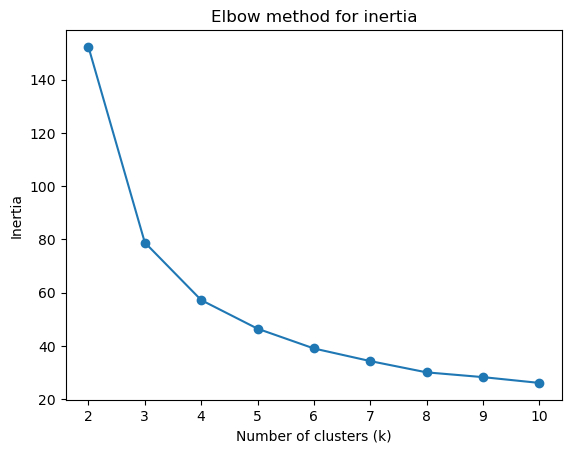

In [16]:
inertias = []
nbr_clusters = range(2,11)

for i in nbr_clusters:
    km = KMeans(n_clusters=i, random_state=0, n_init=10).fit(X)  # Create and fit model
    inertias.append(km.inertia_)     # Store inertia

# Plot      
plt.plot(nbr_clusters, inertias, '-o')
plt.xticks(nbr_clusters)
plt.title('Elbow method for inertia')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.show()

The elbow method tells us to select the cluster when there is a significant change in inertia (i.e., cost). In this case, 4 seems like the optimal number of clusters. From k=5 we see that the reduction in the cost function is much lower than for example for k=3.

### Hierarchical clustering

#### Implementing hierarchical (agglomerative) clustering

We are using the `AgglomerativeClustering` module of sklearn ([Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering))

```python
from sklearn.cluster import AgglomerativeClustering
```
As parameters, we specify:
- `n_clusters`, number of clusters to find (default =2)
    - Instead of specifying the number of clusters, we could also provide the `distance_threshold`, which is the linkage distance threshold at or above which clusters will not be merged. If this case, `n_clusters` must be `None` and `compute_full_tree` must be `True`.
- `metric` is the type of distance metric used, e.g., "euclidean" (default), "l1", "l2", "manhattan", "cosine", or "precomputed"
    - Note: be careful to the sklearn version you are using. `metric` was added since version 1.2. For previous versions, you can use `affinity` (or better update your sklearn version).
- `linkage` is the linkage criterion to use:
    - 'single': minimum of the distances between all observations of the two sets
    - 'complete': maximum distances between all observations of the two sets
    - 'average': average of the distances of each observation of the two sets
    - 'ward' (default): minimizes the variance of the clusters being merged

<img src='https://scikit-learn.org/stable/_images/sphx_glr_plot_linkage_comparison_001.png' width="500">

In [17]:
# Create model
agglomerative3 = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='average')

# Fit model
agglomerative3.fit(X_sepal)

AgglomerativeClustering(linkage='average', metric='euclidean', n_clusters=3)

As before we can access the labels:

In [18]:
print(agglomerative3.labels_)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 0 2 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 0 2 2 2 1 2 2 1 0 1 2 1 2
 2 2 2 2 2 2 1 1 2 2 2 1 2 2 1 2 2 2 1 1 1 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


Let's plot our clusters to visually compare our results to the K-Means algorithm:

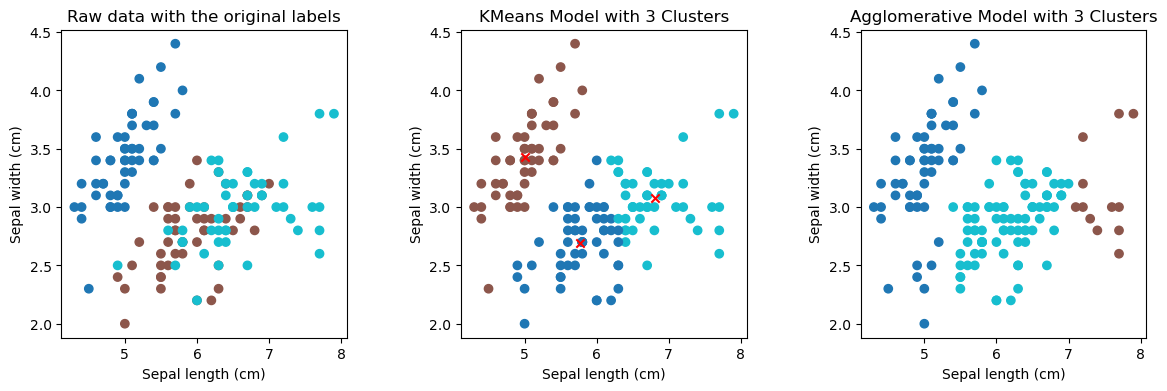

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(14, 4))

# Scatter plot, raw data with original labels
ax[0].scatter(X_sepal["sepal length (cm)"], # x-axis
              X_sepal["sepal width (cm)"],  # y-axis
              c=y['Flower_type'],           # points colored by the different flower types
              cmap='tab10')                 # choice of colors
ax[0].set_xlabel("Sepal length (cm)")       # label x-axis
ax[0].set_ylabel("Sepal width (cm)")        # label y-axis
ax[0].set_title("Raw data with the original labels")  # title

# Scatter plot of clusters, KMeans Model with 3 Clusters
ax[1].scatter(X_sepal["sepal length (cm)"], 
              X_sepal["sepal width (cm)"], 
              c=kmeans3.labels_,              # points colored by the labels created by the model
              cmap='tab10')
ax[1].scatter(kmeans3.cluster_centers_[:, 0],  # x-coordinates of cluster centroids
              kmeans3.cluster_centers_[:, 1],  # y-coordinates of cluster centroids
              c="red",                        # color of centroids
              marker='x')                     # marker of centroids
ax[1].set_xlabel("Sepal length (cm)")
ax[1].set_ylabel("Sepal width (cm)")
ax[1].set_title("KMeans Model with 3 Clusters")

# Scatter plot of clusters, agglomerative clustering with 3 Clusters
ax[2].scatter(X_sepal["sepal length (cm)"], X_sepal["sepal width (cm)"], c=agglomerative3.labels_, cmap='tab10')
ax[2].set_xlabel("Sepal length (cm)")
ax[2].set_ylabel("Sepal width (cm)")
ax[2].set_title("Agglomerative Model with 3 Clusters")

plt.subplots_adjust(wspace=0.4)   # Space between plots
plt.show()

#### Dendrogram visualization

In this section, we're going to present a way to create a **Dendrogram**, using the `scipy.cluster.hierarchy` library ([Documentation](https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html)). We're going to use: 
- `dendogram`: to plot the dendogram ([Documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html#scipy.cluster.hierarchy.dendrogram))
- `linkage`: to specify the type of linkage between the clusters ([Documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage))

In `linkage`, we can specify the `metric` (e.g., 'euclidean') and the `method` (e.g., 'single', 'complete', 'average', or 'ward' - see the documentation for more details).

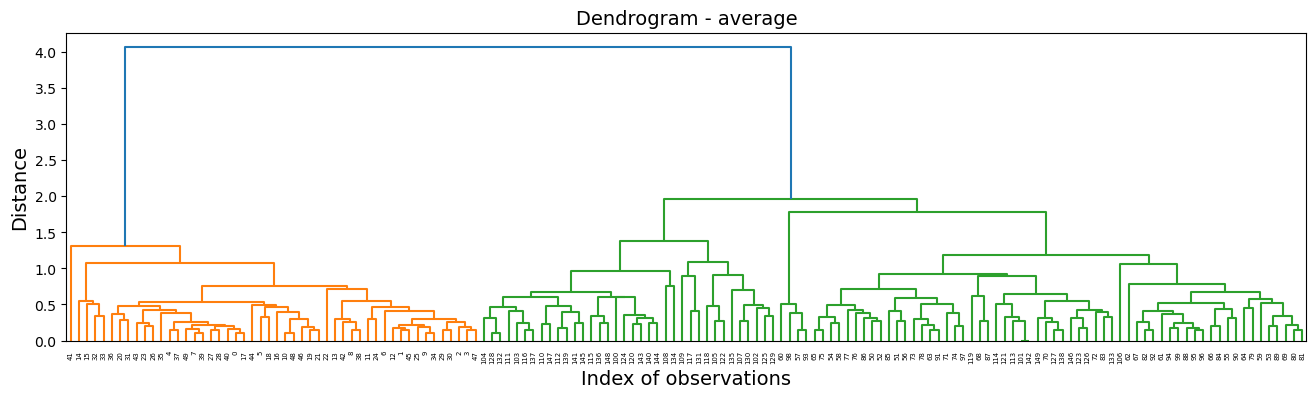

In [20]:
# Provide the linkage method we want and the chosen distance metric.
method_Z = 'average' 
Z = linkage(X, method = method_Z, metric = 'euclidean')

# Single linkage
plt.figure(figsize=(16, 4))
dendrogram(Z) # Plot the dendogram according the linkage
plt.title('Dendrogram - '+method_Z, fontsize=14)
plt.xlabel('Index of observations', fontsize=14)
plt.ylabel('Distance', fontsize=14)
plt.show()

Feel free to try different methods and visualize the difference!

### Runtime complexity

Let's compare the computation time needed between K-means and hierarchical clustering for different numbers of points. To do so, we are using the `time` library ([Documentation](https://docs.python.org/3/library/time.html)).

We'll start by creating clusters of points. We are using `make_blobs` to generate our dataset ([Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html#sklearn.datasets.make_blobs)), and will first define a function with input the number of data points and output the generated samples (X) and associated labels (y):

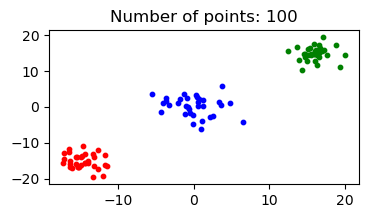

In [90]:
# We create a function that generates 3 clusters
def generate_three_clusters(num_points):
    centers = [(-15, -15), (0, 0), (15, 15)]
    cluster_std = [2, 3, 2]
    X, y = datasets.make_blobs(n_samples=num_points, cluster_std=cluster_std, centers=centers, n_features=3, random_state=1)
    return X, y

# Example with 100 points
X, y = generate_three_clusters(100)
# Plot clusters
plt.figure(figsize=(4,2))
plt.scatter(X[y == 0, 0], X[y == 0, 1], color="red", s=10)
plt.scatter(X[y == 1, 0], X[y == 1, 1], color="blue", s=10)
plt.scatter(X[y == 2, 0], X[y == 2, 1], color="green", s=10)
plt.title('Number of points: 100')
plt.show()

Next we generate 3 clusters using the above-defined function for n = 100, 1000, 2500, 5000, 7500, 10000, 25000 points, storing the result in a list:

In [91]:
# Define list
X_list = []
# Define numbers of points
num_points = [100, 1000, 2500, 5000, 7500, 10000, 25000]

for n in num_points:
    X, y = generate_three_clusters(n)  # Generate three clusters
    X_list.append(X)                   # Append X to X_list

The first item of our list contains 100 points, the second 1000 points, etc.

In [92]:
print(X_list[1].shape)

(1000, 2)


Now we create K-Means and hierarchical clustering models (with 3 clusters), and train the algorithm on the dataset generated above. We store the execution time in two lists, one for K-Means, the other for hierarchical clustering:  

In [93]:
# Record time in list
k_means_time = []
hc_time = []

for X in X_list:
    # K-Means
    model = KMeans(n_clusters=3, n_init='auto')    # Create instance of KMeans class (with 3 clusters)
    start = time.time()                            # Start recording time
    model.fit(X)                                   # Fit the model on X
    end = time.time()                              # End recording time
    k_means_time.append(end-start)                 # Store the execution time in k_means_time
    # Hierarchical clustering
    model = AgglomerativeClustering(n_clusters=3)  # Create instance of AgglomerativeClustering class (3 clusters)
    start = time.time()
    model.fit(X)
    end = time.time()
    hc_time.append(end-start)

Let's plot the result!

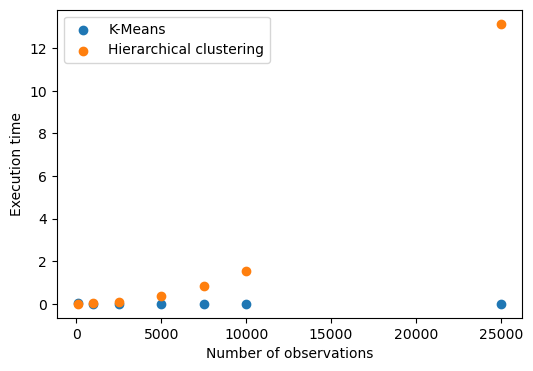

In [94]:
plt.figure(figsize=(6,4))
plt.scatter(num_points, k_means_time, label='K-Means')
plt.scatter(num_points, hc_time, label='Hierarchical clustering')
plt.ylabel('Execution time')
plt.xlabel('Number of observations')
plt.legend()
plt.show()

We can see that for a small number of observations, K-Means takes a bit longer than hierarchical clustering. However, when the number of observations increase, hierarchical clustering takes much longer than K-Means. Indeed, the hierarchical clustering algorithm needs to compute the distance between each observation, and then iteratively between each cluster created. 

## Your turn!

Now it's your turn to practice. We will use a dataset on the customers of a shopping mall, exploring clustering the customers based on their annual income and spending score to see if there are distinguishable clusters which the mall can target.

The dataset was obtained from Dr. Tirthajyoti Sarkar GitHub repository [Machine-Learning-with-Python](https://github.com/tirthajyoti/Machine-Learning-with-Python). I recommend checking it out since it contains amazing ML tutorial and practice notebooks. The following exercise is inspired by the 'Hierarchical_Clustering' notebook of the repository.

In [26]:
# Import dataset
url = 'https://raw.githubusercontent.com/michalis0/MGT-502-Data-Science-and-Machine-Learning/main/data/Mall_Customers.csv'
df = pd.read_csv(url)
df.head(10)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
5,6,Female,22,17,76
6,7,Female,35,18,6
7,8,Female,23,18,94
8,9,Male,64,19,3
9,10,Female,30,19,72


- Discover your dataset, looking at summary statistics, and histograms of income and spending score

In [35]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [45]:

def get_hist_plot(data: pd.DataFrame, columns: list[str], title='Histogram', color=None, log=False):
    '''
    Function that creates a histogram plot on the given data for the given columns.
    xticks_rotation: rotation of xticks in degrees
    '''
    fig, axs = plt.subplots(nrows=1, ncols=len(columns), figsize=(15, 5))

    # Plot each set of data in a different subplot
    for i, col in enumerate(columns):
        x_min = data[col].min()
        x_max = data[col].max()
        axs[i].hist(data[col], log=log, bins=20, edgecolor='black', linewidth=1.2, color=color)
        axs[i].set_xlim([x_min, x_max])
        axs[i].set_title(col.replace('_', ' '), fontsize=12)
        axs[i].set_ylabel('# observations', fontsize=12)
        axs[i].tick_params(axis='both', which='major', labelsize=10)
        axs[i].grid(axis='y', alpha=0.5)
        axs[i].spines['right'].set_visible(False)
        axs[i].spines['top'].set_visible(False)
    fig.suptitle(title, fontsize=16, y=1.05)
    # Increase spacing between subplots
    fig.subplots_adjust(wspace=0.4)
    return plt


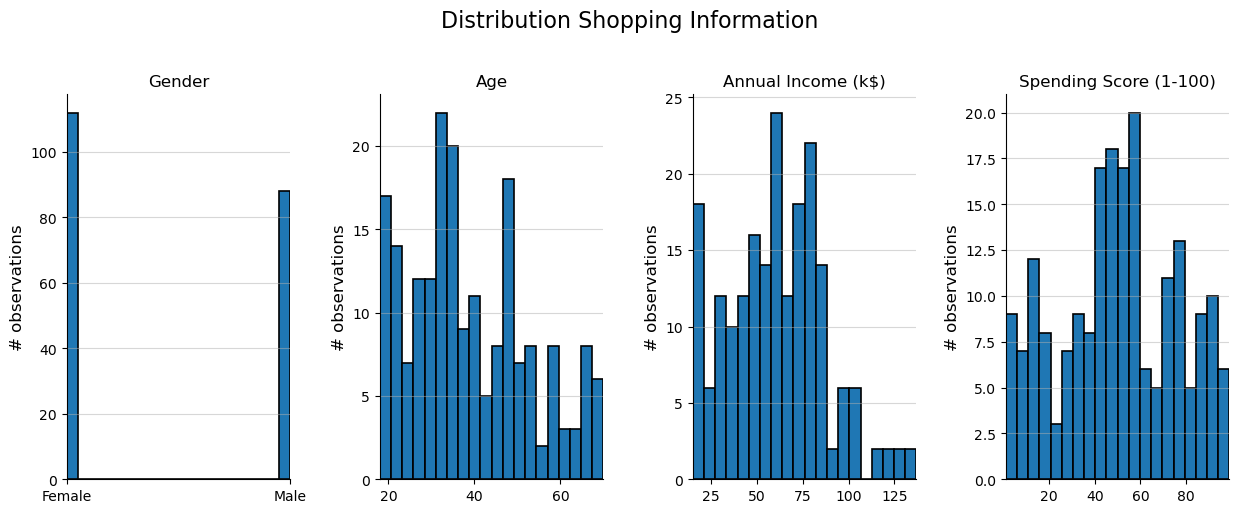

In [46]:
cols = df.columns.tolist()[1:]

get_hist_plot(data=df, columns=cols, title='Distribution Shopping Information').show()


- Do a scatter plot of income and spending score... Does your plot help you define the number of clusters?

In [52]:
cols

['Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


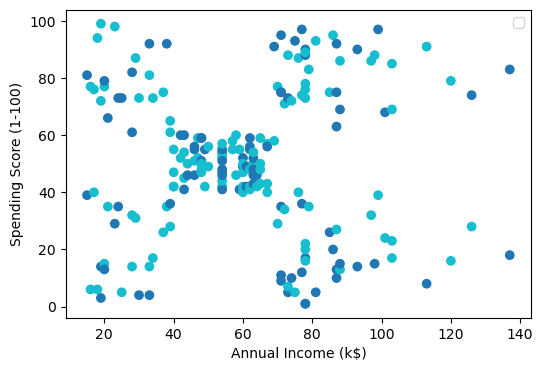

In [96]:
x = "Annual Income (k$)"
y = "Spending Score (1-100)"

plt.figure(figsize=(6, 4))
# Scatter plot, raw data with original labels
plt.scatter(x=df[x],  # x-axis
            y=df[y],
            c=df['Gender'].replace({'Male': 0, 'Female': 1}),
            cmap='tab10')  
# points colored by the different flower types
plt.xlabel(x)
plt.legend()
plt.ylabel(y)
plt.show()


Looks like we have 5 different clusters!

Dendograms can also be used to gain insights on the optimal number of clusters.

- Plot a dendogram varying the linkage method. How many clusters do you think is optimal? You can apply the following technique:
    - Look for the longest stretch of vertical line which is not crossed by any "extended horizontal lines" (horizontal lines grouping clusters that are extended infinitely to both directions).
    - Take any point on that stretch of line and draw an imaginary horizontal line.
    - Count how many vertical lines this imaginary lines crossed.
    - That is likely to be the optimal number of clusters. 

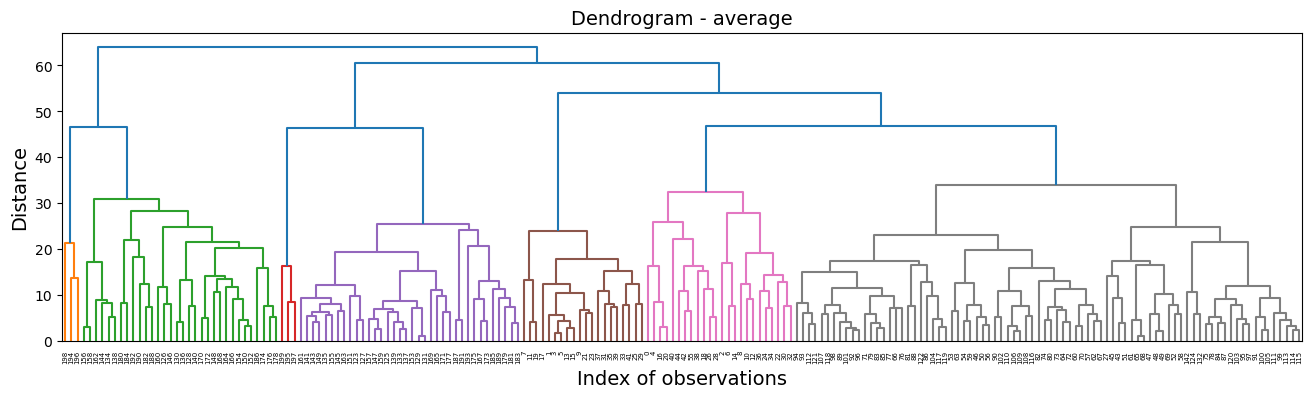

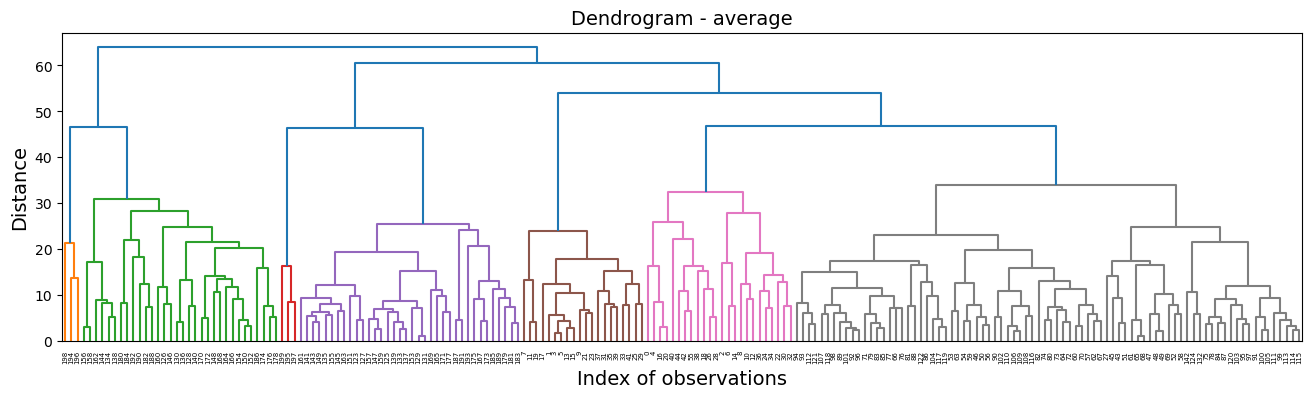

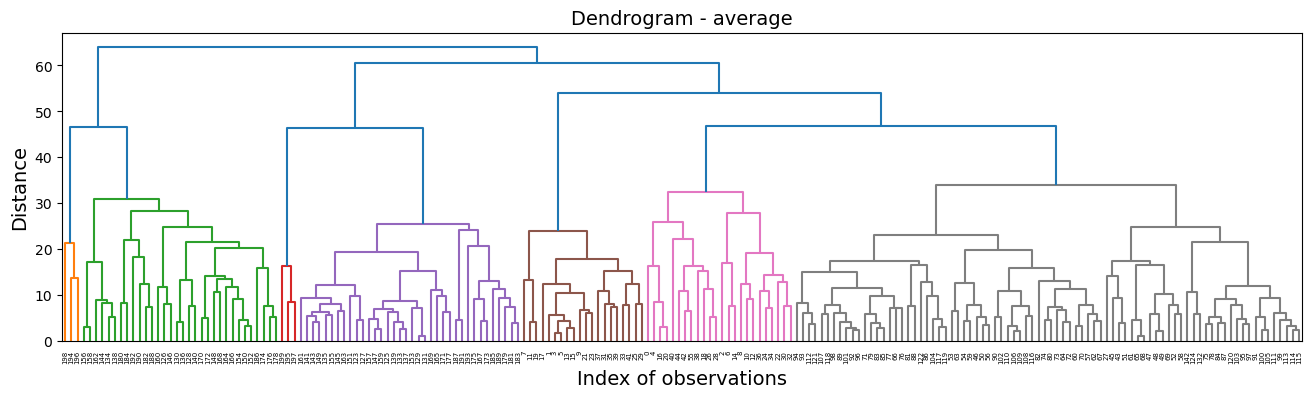

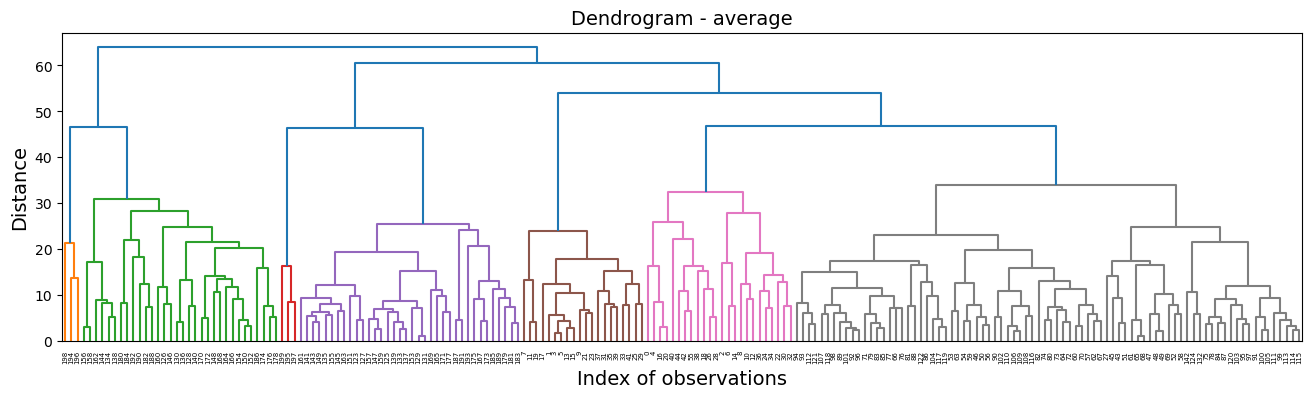

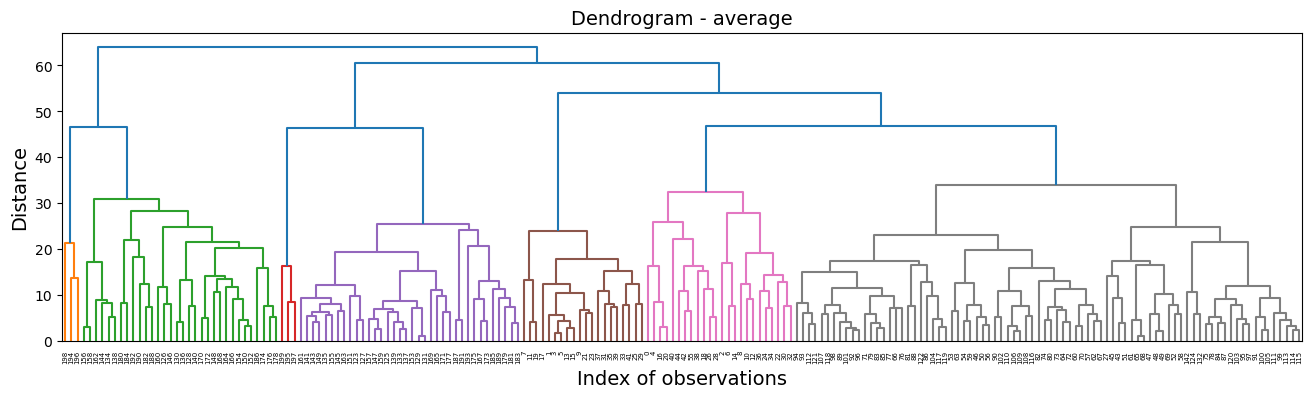

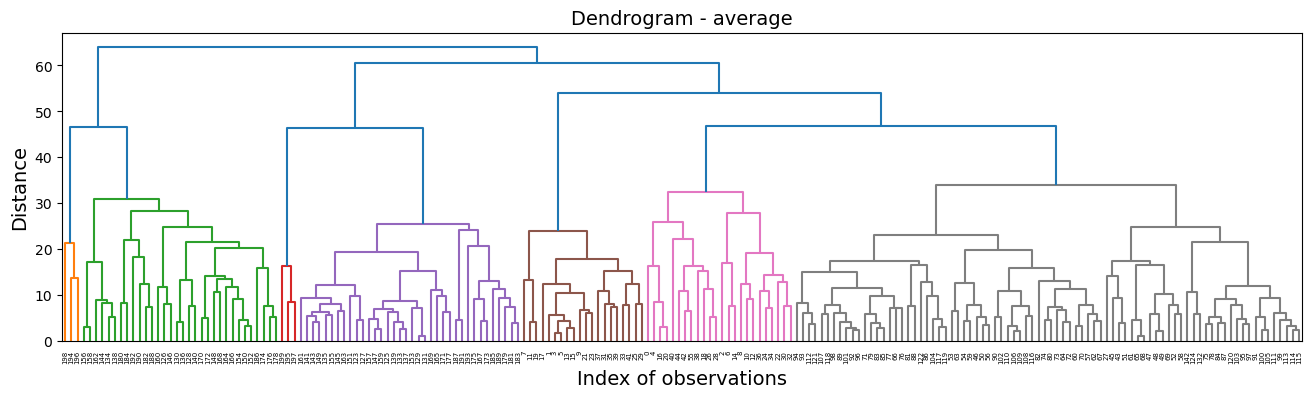

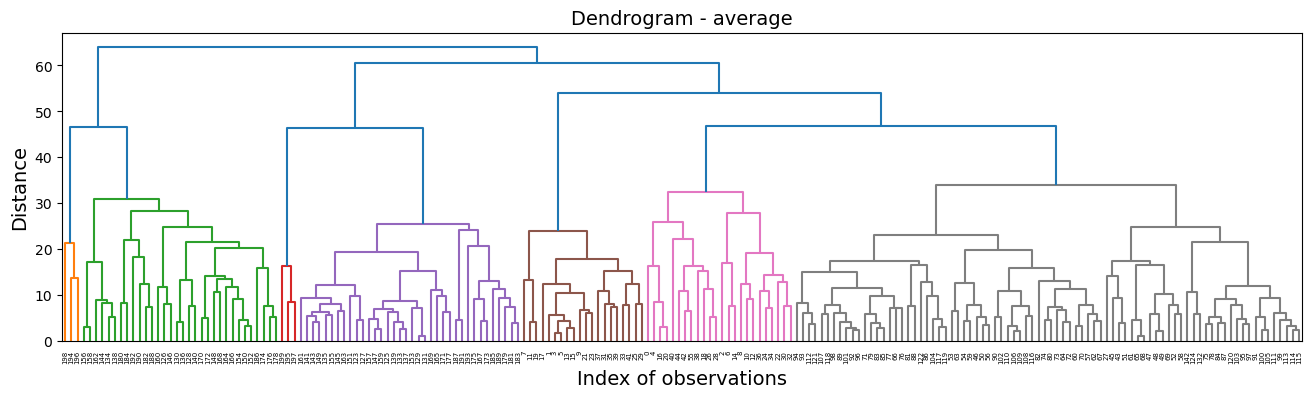

In [78]:
# Provide the linkage method we want and the chosen distance metric.
z_method = ['single', 'complete', 'average',
            'weighted', 'centroid', 'median', 'ward']

for z in z_method:
    Z = linkage(df[cols[1:]], method=method_Z, metric='euclidean')

    # Single linkage
    plt.figure(figsize=(16, 4))

    dendrogram(Z)  # Plot the dendogram according the linkage
    plt.title('Dendrogram - '+method_Z, fontsize=14)
    plt.xlabel('Index of observations', fontsize=14)
    plt.ylabel('Distance', fontsize=14)
    plt.show()


We will now implement clustering algorithms using 5 clusters representing 5 customer groups:
- *Careful* - high income but low spenders
- *Standard* - middle income and middle spenders
- ***Target group*** - middle-to-high income and high spenders (should be targeted by the mall
- *Careless* - low income but high spenders (should be avoided because of possible credit risk)
- *Sensible* - low income and low spenders

Let's start with K-Means.

- Implement a K-Means algorithm, using as features the annual income and the spending score, with 5 clusters. Also print the execution time.

In [103]:
kmeans5_customer = KMeans(n_clusters=5, random_state=0, n_init='auto') #5 clusters

X_income_spending = df[cols[2:]]
display(X_income_spending)

start = time.time()   
kmeans5_customer.fit(X_income_spending)
end = time.time()  

print(f'Running time: {round(end-start, 3)}ms')

,Annual Income (k$),Spending Score (1-100)
0,15,39
1,15,81
2,16,6
3,16,77
4,17,40
...,...,...
195,120,79
196,126,28
197,126,74
198,137,18


Running time: 0.005ms


In [105]:
X_income_spending.columns.values

array(['Annual Income (k$)', 'Spending Score (1-100)'], dtype=object)

- Make a scatter plot of the annual income and spending score, colored by the cluster they belong to, adding to the figure the cluster centers

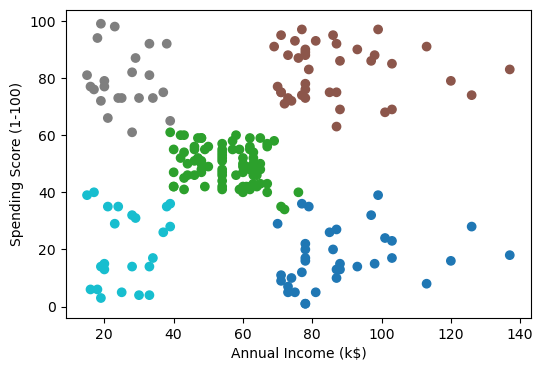

In [121]:
x = "Annual Income (k$)"
y = "Spending Score (1-100)"

plt.figure(figsize=(6, 4))
# Scatter plot, raw data with original labels
plt.scatter(x=df[x],  # x-axis
            y=df[y],
            c=kmeans5_customer.labels_,
            cmap='tab10')  
# points colored by the different flower types
plt.xlabel(x)
plt.ylabel(y)
plt.show()


- Implement the elbow method to determine the optimum number of cluster. Does the elbow method confirm our previous choice of 5 clusters?

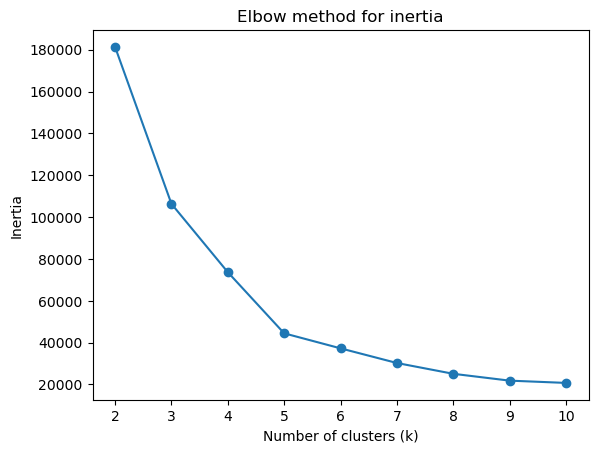

In [122]:
inertias = []
nbr_clusters = range(2,11)

for i in nbr_clusters:
    km = KMeans(n_clusters=i, random_state=0, n_init=10).fit(X_income_spending)  # Create and fit model
    inertias.append(km.inertia_)     # Store inertia

# Plot      
plt.plot(nbr_clusters, inertias, '-o')
plt.xticks(nbr_clusters)
plt.title('Elbow method for inertia')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.show()

- Implement a hierarchical algorithm with 5 clusters and the linkage method of your choice. Print the execution time

In [129]:
# Create model
agglomerative5 = AgglomerativeClustering(n_clusters=5, metric='euclidean', linkage='average')

# Fit model
start = time.time()
agglomerative5.fit(X_income_spending)
end = time.time()
print(f'Agglomerative with 5 clusters spent: {round(end-start, 3)}ms')

Agglomerative with 5 clusters spent: 0.003ms


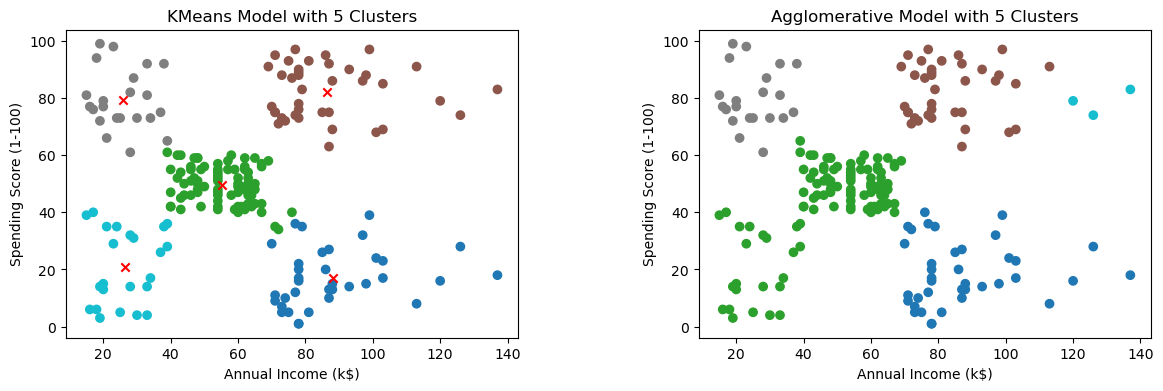

In [132]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))

x = "Annual Income (k$)"
y = "Spending Score (1-100)"

ax[0].scatter(x=df[x],  # x-axis
              y=df[y],
              c=kmeans5_customer.labels_,
              cmap='tab10')
ax[0].scatter(kmeans5_customer.cluster_centers_[:, 0],
              kmeans5_customer.cluster_centers_[:, 1],
              c="red",
              marker='x')
ax[0].text(1.23, 11.4, 'Point A')  # Point A label
ax[0].text(1.23, 12.9, 'Point B')       # Point B label
ax[0].set_title("KMeans Model with 5 Clusters")
ax[0].set_xlabel(x)
ax[0].set_ylabel(y)

ax[1].scatter(x=df[x],  # x-axis
              y=df[y],
              c=agglomerative5.labels_,
              cmap='tab10')
ax[1].set_title("Agglomerative Model with 5 Clusters")
ax[1].set_xlabel(x)
ax[1].set_ylabel(y)


plt.subplots_adjust(wspace=0.4)   # Space between plots
plt.show()


- Make a scatter plot of the annual income and spending score, colored by the cluster they belong to. How does your algorithms compare?

Looks like the KMeans model performed better at finding the different categories.